# Evaluation of model performance

Evaluation...

In [3]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import scipy.stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer

from src.data.data_scaler import PreProcess
from src.data.data_loader import MIMICDataset,import_data,collate_fn_padd
from src.utils import setup_logger
from src.training.training_nn import *
from src.models.models import ODERNN,LatentODE1
from src.utils import seed_everything

In [4]:
from data.feature_sets import all_features

In [5]:
def glc_transform(x):
    x = x.copy()
    x[x > 0] = np.log(x[x > 0]) - np.log(140)
    return x

def glc_invtransform(x):
    x = x.copy()
    x = np.exp(x + np.log(140))
    return x

ginv = glc_invtransform

In [6]:
preproc = PreProcess(all_features(),QuantileTransformer())
df_train = pd.read_csv('data/train.csv')
preproc.fit(df_train)

## Model

In [7]:
model_path = 'experiments/mimic/LatentODE1.pth'
cpt = torch.load(model_path)

In [8]:
print(len(all_features()))

99


In [9]:
model = LatentODE1(99, 8, 0.1, 1,128,"cpu").to("cpu")

In [10]:
model.load_state_dict(cpt['state_dict'])

<All keys matched successfully>

In [11]:
model

LatentODE1(
  (func): LatentODE1_(
    (net): Sequential(
      (0): Linear(in_features=107, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=8, bias=True)
      (3): Tanh()
    )
  )
  (mu_net): Sequential(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): Tanh()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
  (sigma_net): Sequential(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): Tanh()
    (2): Linear(in_features=8, out_features=1, bias=True)
    (3): Softplus(beta=1, threshold=20)
  )
  (jumpNN): Sequential(
    (0): Linear(in_features=99, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=8, bias=True)
    (3): Tanh()
  )
)

## Test data

In [12]:
df_test = import_data("data/test.csv")
print(df_test.shape)

(78557, 111)


In [13]:
df_test = preproc.transform(df_test)

In [14]:
df_test['dt'] = df_test.timer_dt - df_test.timer

(array([55924.,     0.,     0.,     0.,     0.,     0.,   166.,  7399.,
         7627.,  7441.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

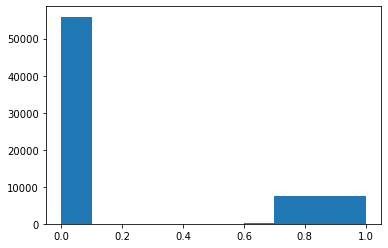

In [15]:
plt.hist(df_test.input_hrs)

# Predict

In [16]:
dl_test = DataLoader(MIMICDataset(df_test,all_features()),batch_size=256,collate_fn=collate_fn_padd)
dataloaders = {'test':dl_test}
loss_test,error_tests,y_preds,y_tests,msks = model.evaluate(dataloaders["test"])

reconfiguring data...
excluded patients: 0
excluded rows: 0


100%|██████████| 17/17 [00:16<00:00,  1.01it/s]

_rmse : 40.984
_loss : -0.027


In [17]:
mu,sig = model.predict(dataloaders["test"])

100%|██████████| 17/17 [00:15<00:00,  1.12it/s]


In [18]:
next(iter(dl_test))[0].shape

torch.Size([256, 233, 99])

(array([  786.,  5794., 11546., 17010., 16481.,  9544.,  4919.,  2735.,
         1682.,   917.]),
 array([-0.57715786, -0.44387394, -0.31059003, -0.17730612, -0.0440222 ,
         0.08926171,  0.22254562,  0.35582954,  0.48911345,  0.62239736,
         0.7556813 ], dtype=float32),
 <BarContainer object of 10 artists>)

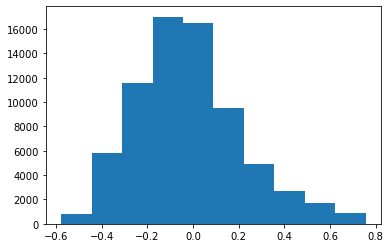

In [19]:
plt.hist(mu)

In [20]:
sig.shape

(71414,)

In [21]:
df_test.loc[df_test.msk==0].shape

(71414, 112)

## Evaluate

text

In [ ]:
df_test['mu'] = np.concatenate(mu)
df_test['sig'] = np.concatenate(sig)
df_test['lower80'] = df_test['mu'] - 1.281552*df_test['sig']
df_test['upper80'] = df_test['mu'] + 1.281552*df_test['sig']
df_test['lower95'] = df_test['mu'] - 1.959964*df_test['sig']
df_test['upper95'] = df_test['mu'] + 1.959964*df_test['sig']
df_test['lower99'] = df_test['mu'] - 3.290527*df_test['sig']
df_test['upper99'] = df_test['mu'] + 3.290527*df_test['sig']

In [ ]:
res80 = sum((df_test['lower80'] < df_test.glc_dt) & (df_test['upper80'] > df_test.glc_dt) & (df_test.msk == 0)) / sum(df_test.msk == 0)
res95 = sum((df_test['lower95'] < df_test.glc_dt) & (df_test['upper95'] > df_test.glc_dt) & (df_test.msk == 0)) / sum(df_test.msk == 0)
res99 = sum((df_test['lower99'] < df_test.glc_dt) & (df_test['upper99'] > df_test.glc_dt) & (df_test.msk == 0)) / sum(df_test.msk == 0)
print("coverage of 80% prediction interval: {:05.4f}".format(res80))
print("coverage of 95% prediction interval: {:05.4f}".format(res95))
print("coverage of 99% prediction interval: {:05.4f}".format(res99))

In [ ]:
dts = np.linspace(0,11,12)
dts = np.append(dts,12.)
for i in range(dts.shape[0]-1):
    print('time ahead (hours): {:05.2f}-{:05.2f}'.format(dts[i],dts[i+1]))
    msk = (df_test.msk==0) & (df_test.dt >= dts[i]) & (df_test.dt < dts[i+1])
    res80 = sum((df_test['lower80'] < df_test.glc_dt) & (df_test['upper80'] > df_test.glc_dt) & msk) / sum(msk)
    res95 = sum((df_test['lower95'] < df_test.glc_dt) & (df_test['upper95'] > df_test.glc_dt) & msk) / sum(msk)
    res99 = sum((df_test['lower99'] < df_test.glc_dt) & (df_test['upper99'] > df_test.glc_dt) & msk) / sum(msk)
    print("coverage of 80% prediction interval: {:05.4f}".format(res80))
    print("coverage of 95% prediction interval: {:05.4f}".format(res95))
    print("coverage of 99% prediction interval: {:05.4f}".format(res99))

In [ ]:
print("interval coverage when hypoglycaemia region...")
dts = np.linspace(0,11,12)
dts = np.append(dts,12.)
for i in range(dts.shape[0]-1):
    print('time ahead (hours): {:05.2f}-{:05.2f}'.format(dts[i],dts[i+1]))
    msk = (df_test.msk==0) & (df_test.dt >= dts[i]) & (df_test.dt < dts[i+1]) & (ginv(df_test.glc_dt) < 70)
    res80 = sum((df_test['lower80'] < df_test.glc_dt) & (df_test['upper80'] > df_test.glc_dt) & msk) / sum(msk)
    res95 = sum((df_test['lower95'] < df_test.glc_dt) & (df_test['upper95'] > df_test.glc_dt) & msk) / sum(msk)
    res99 = sum((df_test['lower99'] < df_test.glc_dt) & (df_test['upper99'] > df_test.glc_dt) & msk) / sum(msk)
    print("coverage of 80% prediction interval: {:05.4f}".format(res80))
    print("coverage of 95% prediction interval: {:05.4f}".format(res95))
    print("coverage of 99% prediction interval: {:05.4f}".format(res99))

In [ ]:
dts = np.linspace(0,6,10)
for dt in dts:
    print("interval coverage when hypoglycaemia region...")
    print('time ahead (hours): {:05.2f}'.format(dt))
    _msk_ = (df_test.msk == 0) & (ginv(df_test.glc_dt) < 70) & (df_test.timer_dt - df_test.timer > dt)
    res80 = sum((df_test['lower80'] < df_test.glc_dt) & (df_test['upper80'] > df_test.glc_dt) & _msk_) / sum(_msk_)
    res95 = sum((df_test['lower95'] < df_test.glc_dt) & (df_test['upper95'] > df_test.glc_dt) & _msk_) / sum(_msk_)
    res99 = sum((df_test['lower99'] < df_test.glc_dt) & (df_test['upper99'] > df_test.glc_dt) & _msk_) / sum(_msk_)
    print("coverage of 80% prediction interval: {:05.4f}".format(res80))
    print("coverage of 95% prediction interval: {:05.4f}".format(res95))
    print("coverage of 99% prediction interval: {:05.4f}".format(res99))

In [ ]:
df_test["glc_dt_locf"] = df_test.glc
df_test.loc[df_test.glc_dt_locf == 0,'glc_dt_locf'] = np.NaN
df_test["glc_dt_locf"] = df_test.groupby('icustay_id')["glc_dt_locf"].ffill()
res_rmse_locf = math.sqrt(np.mean((ginv(df_test.glc_dt_locf[df_test.msk==0]) - ginv(df_test.glc_dt[df_test.msk==0]))**2))
print("RMSE (locf): {:05.4f}".format(res_rmse_locf))

In [ ]:
res_rmse_model = math.sqrt(np.mean((ginv(df_test.mu[df_test.msk==0]) - ginv(df_test.glc_dt[df_test.msk==0]))**2))
print("RMSE (model): {:05.4f}".format(res_rmse_model))

In [ ]:
print("RMSE...")
dts = np.linspace(0,11,12)
dts = np.append(dts,12.)
dts[0] = 0.5
for i in range(dts.shape[0]-1):
    print('time ahead (hours): {:05.2f}-{:05.2f}'.format(dts[i],dts[i+1]))
    msk = (df_test.msk==0) & (df_test.dt >= dts[i]) & (df_test.dt < dts[i+1])
    print("N: {:5}".format(sum(msk)))
    res_rmse_locf = math.sqrt(np.mean((ginv(df_test.glc_dt_locf[msk]) - ginv(df_test.glc_dt[msk]))**2))
    print("RMSE (locf): {:05.4f}".format(res_rmse_locf))
    res_rmse_model = math.sqrt(np.mean((ginv(df_test.mu[msk]) - ginv(df_test.glc_dt[msk]))**2))
    print("RMSE (model): {:05.4f}".format(res_rmse_model))
    print("{:05.4f}".format(res_rmse_model/res_rmse_locf))

In [ ]:
# dts = np.linspace(0,6,10)
# for dt in dts:
#     print('time ahead (hours): {:05.2f}'.format(dt))
#     msk = (df_test.msk==0) & (df_test.timer_dt - df_test.timer > dt)
#     res_rmse_locf = math.sqrt(np.mean((ginv(df_test.glc_dt_locf[msk]) - ginv(df_test.glc_dt[msk]))**2))
#     print("RMSE (locf): {:05.4f}".format(res_rmse_locf))
#     res_rmse_model = math.sqrt(np.mean((ginv(df_test.mu[msk]) - ginv(df_test.glc_dt[msk]))**2))
#     print("RMSE (model): {:05.4f}".format(res_rmse_model))
#     print("{:05.4f}".format(res_rmse_model/res_rmse_locf))

In [ ]:
import random
fig, axs = plt.subplots(4,1,figsize=(6,12))
plt.rcParams['font.size'] = '16'

ids = random.sample(list(df_test.icustay_id.unique()),4)
for i in range(4):
    msk_i = (df_test['icustay_id'] == ids[i]) & (df_test['timer_dt'] < 48)
    xs = df_test[msk_i].timer_dt
    axs[i].plot(xs,glc_invtransform(df_test.mu[msk_i]),label='predictions',linestyle='--', marker='o', color='b')
    axs[i].plot(xs, glc_invtransform(df_test.lower95[msk_i]),label='',linestyle='--', color='lightblue')
    axs[i].plot(xs,glc_invtransform(df_test.upper95[msk_i]),label='',linestyle='--', color='lightblue')
#     axs[i].fill_between(xs,glc_invtransform(df_test.mu[msk_i])-glc_invtransform(df_test.lower95[msk_i]),
#                         glc_invtransform(df_test.mu[msk_i])+glc_invtransform(df_test.lower95[msk_i]),
#                         label='', color='lightblue',interpolate=True)
    axs[i].scatter(xs,glc_invtransform(df_test.glc_dt[msk_i]),label='truth', marker='o', color='red')
    axs[i].set_xlabel('Time in ICU (hours)', fontsize=12)
    axs[i].set_ylabel('Blood glucose\n(mg/dL)', fontsize=12)
    axs[i].set_xlim(0,48)
    axs[i].set_title(ids[i])
    if i == 0:
        axs[i].legend(fontsize = 'x-small')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
mu = [y[0] for y in y_preds]
sig = [y[1] for y in y_preds]
mu = np.concatenate(mu)
sig = np.concatenate(sig)
y_tests = np.concatenate(y_tests)

In [ ]:
prob_test = scipy.stats.norm(mu, sig).cdf(y_tests)

In [ ]:
# a forecast is overdispersed if var < 0.8333 and underdispersed if var > 0.8333
print(1/12)
varF = np.var(prob_test[~msks])
print('variance of probs: {:05.4f}'.format(varF))
if varF > 1/12:
    print("underdispersed")
else: 
    print("overdispersed")

In [ ]:
plt.hist(prob_test[~msks], color=['#0504aa'],alpha=0.7, bins=20)
plt.xlabel("Probability integral transform")
plt.show()

In [ ]:
prob_test[~msks]

In [ ]:
df_test['probs'] = prob_test

In [ ]:
df_test.to_csv('data/eval/test.csv',index=False)

In [ ]:
prob_test[~msks]

In [ ]:
# quantile plot
def calibration_plot(prob_test):
    nbins = 20
    x1s = plt.hist(prob_test,bins=nbins)
    plt.close()
    xbin = np.zeros(nbins)
    for i in range(nbins):
        xbin[i] = (x1s[1][i] + x1s[1][i+1])/2
    qs = np.cumsum(x1s[0])/sum(x1s[0])
    errors = np.sqrt(qs*(1-qs)/sum(x1s[0]))
    plt.scatter(xbin,qs)
    plt.errorbar(xbin, qs, yerr=2*errors, fmt='o')
    plt.plot(np.linspace(0,1),np.linspace(0,1),'--r')
    plt.xlabel("Predicted quantile")
    plt.ylabel("Empirical quantile")
    plt.show()
calibration_plot(prob_test[~msks])

In [ ]:
x,y,msk,t = next(iter(dataloaders["test"]))

In [ ]:
ginv(x[:,:,0].numpy())

In [ ]:
t[0]

In [ ]:
x[0][0]

In [ ]:
x[0][0][5] = 0.0

In [ ]:
ginv(model(t.to("cuda"),x.to("cuda"))[0].detach().cpu().numpy())

In [ ]:
all_features()[0:11]

In [ ]:
x = x[:,0:2,:]
t = t[:,0:2,:]

In [ ]:
ntimes = 100
ninsulin = 10
x[:,1,1] = 0.0
x[:,1,4] = 0.0
x[:,1,2] = 0.0
x[:,1,3] = 0.0
res = np.zeros((10,ntimes))
insulin = np.concatenate((np.zeros((1,1)),np.linspace(0.7,1.0,ninsulin-1).reshape(-1,1)))
times = np.linspace(0.5,6,100)
for i in range(ninsulin):
    x[:,1,1] = insulin[i,:].item()
    for j in range(ntimes):
        t[:,1,1] = t[:,1,0] + times[j]
        mu,sig = model(t.to("cuda"),x.to("cuda"))
        res[i,j] = mu[1].detach().cpu().item()

In [ ]:
insulin 

In [ ]:
for p in range(ninsulin):
    plt.plot(times,ginv(res[p]))
plt.show()

In [ ]:
res

In [ ]:
inject_times = df_test.loc[df_test.input_short_injection > 0,["timer","timer_dt"]]

In [ ]:
plt.hist(inject_times.timer_dt - inject_times.timer,bins=100)
plt.xlim(0,24)

## Predict with dropout

In [ ]:
B = 10
res_mu = np.zeros((B,df_test.shape[0]))
res_sig = np.zeros((B,df_test.shape[0]))
with tqdm(total=B) as t:
    for b in range(B):
        loss,rmse, y_preds_b, ll,jj = model.evaluate(dataloaders["test"],p=0.1,verbose=False)
        mu_b = np.concatenate([y[0] for y in y_preds_b])
        sig_b = np.concatenate([y[1] for y in y_preds_b])
        res_mu[b,:] = mu_b.squeeze(1)
        res_sig[b,:] = sig_b.squeeze(1)
        t.update()

In [ ]:
res_mu_mean = np.mean(res_mu,axis=0)
res_sig_mean = np.median(res_sig,axis=0)

In [ ]:
dts = np.linspace(0,6,10)
for dt in dts:
    print('time ahead (hours): {:05.2f}'.format(dt))
    msk = (df_test.msk==0) & (df_test.timer_dt - df_test.timer > dt)
    res_rmse_locf = math.sqrt(np.mean((ginv(df_test.glc_dt_locf[msk]) - ginv(df_test.glc_dt[msk]))**2))
    print("RMSE (locf): {:05.4f}".format(res_rmse_locf))
    res_rmse_model = math.sqrt(np.mean((ginv(res_mu_mean[msk]) - ginv(df_test.glc_dt[msk]))**2))
    print("RMSE (model): {:05.4f}".format(res_rmse_model))
    print("{:05.4f}".format(res_rmse_model/res_rmse_locf))

In [ ]:
prob_test_B = scipy.stats.norm(np.expand_dims(res_mu_mean,1), np.expand_dims(res_sig_mean,1)).cdf(y_tests)

In [ ]:
# a forecast is overdispersed if var < 0.8333 and underdispersed if var > 0.8333
print(1/12)
varF = np.var(prob_test_B[~msks])
print('variance of probs: {:05.4f}'.format(varF))
if varF > 1/12:
    print("underdispersed")
else: 
    print("overdispersed")

In [ ]:
plt.hist(prob_test_B[~msks], color=['#0504aa'],alpha=0.7, bins=20)
plt.xlabel("Probability integral transform")
plt.show()

In [ ]:
# quantile plot
def calibration_plot(prob_test):
    nbins = 20
    x1s = plt.hist(prob_test,bins=nbins)
    plt.close()
    xbin = np.zeros(nbins)
    for i in range(nbins):
        xbin[i] = (x1s[1][i] + x1s[1][i+1])/2
    qs = np.cumsum(x1s[0])/sum(x1s[0])
    errors = np.sqrt(qs*(1-qs)/sum(x1s[0]))
    plt.scatter(xbin,qs)
    plt.errorbar(xbin, qs, yerr=2*errors, fmt='o')
    plt.plot(np.linspace(0,1),np.linspace(0,1),'--r')
    plt.xlabel("Predicted quantile")
    plt.ylabel("Empirical quantile")
    plt.show()
calibration_plot(prob_test_B[~msks])

In [ ]:
df_test['muB'] = (res_mu_mean)
df_test['sigB'] = (res_sig_mean)
df_test['lower80B'] = df_test['muB'] - 1.281552*df_test['sigB']
df_test['upper80B'] = df_test['muB'] + 1.281552*df_test['sigB']
df_test['lower95B'] = df_test['muB'] - 1.959964*df_test['sigB']
df_test['upper95B'] = df_test['muB'] + 1.959964*df_test['sigB']
df_test['lower99B'] = df_test['muB'] - 3.290527*df_test['sigB']
df_test['upper99B'] = df_test['muB'] + 3.290527*df_test['sigB']

In [ ]:
res80 = sum((df_test['lower80B'] < df_test.glc_dt) & (df_test['upper80B'] > df_test.glc_dt) & (df_test.msk == 0)) / sum(df_test.msk == 0)
res95 = sum((df_test['lower95B'] < df_test.glc_dt) & (df_test['upper95B'] > df_test.glc_dt) & (df_test.msk == 0)) / sum(df_test.msk == 0)
res99 = sum((df_test['lower99B'] < df_test.glc_dt) & (df_test['upper99B'] > df_test.glc_dt) & (df_test.msk == 0)) / sum(df_test.msk == 0)
print("coverage of 80% prediction interval: {:05.4f}".format(res80))
print("coverage of 95% prediction interval: {:05.4f}".format(res95))
print("coverage of 99% prediction interval: {:05.4f}".format(res99))

In [ ]:
print("interval coverage when hypoglycaemia region...")
_msk_ = (df_test.msk == 0) & (ginv(df_test.glc_dt) < 70)
res80 = sum((df_test['lower80B'] < df_test.glc_dt) & (df_test['upper80B'] > df_test.glc_dt) & _msk_) / sum(_msk_)
res95 = sum((df_test['lower95B'] < df_test.glc_dt) & (df_test['upper95B'] > df_test.glc_dt) & _msk_) / sum(_msk_)
res99 = sum((df_test['lower99B'] < df_test.glc_dt) & (df_test['upper99B'] > df_test.glc_dt) & _msk_) / sum(_msk_)
print("coverage of 80% prediction interval: {:05.4f}".format(res80))
print("coverage of 95% prediction interval: {:05.4f}".format(res95))
print("coverage of 99% prediction interval: {:05.4f}".format(res99))

In [ ]:
dts = np.linspace(0,6,10)
for dt in dts:
    print("interval coverage when hypoglycaemia region...")
    print('time ahead (hours): {:05.2f}'.format(dt))
    _msk_ = (df_test.msk == 0) & (ginv(df_test.glc_dt) < 70) & (df_test.dt > dt)
    res80 = sum((df_test['lower80B'] < df_test.glc_dt) & (df_test['upper80B'] > df_test.glc_dt) & _msk_) / sum(_msk_)
    res95 = sum((df_test['lower95B'] < df_test.glc_dt) & (df_test['upper95B'] > df_test.glc_dt) & _msk_) / sum(_msk_)
    res99 = sum((df_test['lower99B'] < df_test.glc_dt) & (df_test['upper99B'] > df_test.glc_dt) & _msk_) / sum(_msk_)
    print("coverage of 80% prediction interval: {:05.4f}".format(res80))
    print("coverage of 95% prediction interval: {:05.4f}".format(res95))
    print("coverage of 99% prediction interval: {:05.4f}".format(res99))

In [ ]:
model(torch.randn(1,1,4),torch.rand(1,1))

In [ ]:
# injection 	input_hrs 	input 	glc
x_ = torch.tensor([0.,0.,0.,glc_transform(np.array(200.0))]).unsqueeze(0).unsqueeze(0).float()
dt_ = torch.tensor([1.0]).unsqueeze(0).float()
ys_ = model(x_,dt_)
ginv(ys_[0].detach().cpu().numpy())

In [ ]:
x_ = torch.tensor([0.,12.,0.,glc_transform(np.array(200.0))]).unsqueeze(0).unsqueeze(0).float()
dt_ = torch.tensor([1.0]).unsqueeze(0).float()
ys_ = model(x_,dt_)
ginv(ys_[0].detach().cpu().numpy())

In [ ]:
x_ = torch.tensor([1.,0.,20.,glc_transform(np.array(200.0))]).unsqueeze(0).unsqueeze(0).float()
dt_ = torch.tensor([1.0]).unsqueeze(0).float()
ys_ = model(x_,dt_)
ginv(ys_[0].detach().cpu().numpy())

In [ ]:
x_ = torch.tensor(np.array(([1.,0.,4.,0.],[1.,0.,4.,0.]))).unsqueeze(0).float()
dt_ = torch.tensor(np.array(([2.0],[2.0]))).unsqueeze(0).unsqueeze(0).float()
ys_ = model(x_,dt_)
ginv(ys_[0].detach().numpy())

In [ ]:
FEATURE_VARS = ["injection","input_hrs","input","glc"]

In [ ]:
torch.tensor(np.array(([1.,0.,4.,0.],[1.,0.,4.,0.]))).shape

In [ ]:
x_ = torch.tensor(np.array(([0.,0.,0.,glc_transform(np.array(150.0))],[0.,10.,0.,0.]))).float()
dt_ = torch.tensor(np.array(([2354.],[0.4]))).float()
ys_ = model(x_,dt_)


In [ ]:
ginv(ys_[0].detach().numpy())